# Chapter 19: Constrained nonlinear least squares 

We extend the previous chapter of nonlinear least squares problem to include nonlinear constraints. Because this problem is hard to solve exactly, we will describe heuristic algorithms that often work well in practice. 

## 19.1 Constrained nonlinear least squares 

The constrained nonlinear least squares extends the nonlinear least squares problem: 

\begin{align}
    & \text{minimize} \quad ||f(x)||^2 (= f_1(x)^2 + \cdots + f_m(x)^2) \\
    & \text{subject to} \quad g(x) = 0, (= g_1(x) = 0, \dots, g_p(x) = 0)
\end{align}

$x$ is called feasible for the problem if it satisfies $g(x) = 0$. $\hat x$ is a solution of the problem above if it is feasible and has the smallest objective among all feasible points. 

**Linear equality constraints.** When $f(x)$ is nonlinear but $g(x)$ is affine ($g(x) = 0$ can be written as $Cx=d$ for some $p \times n$ matrix $C$ and a $p$-vector $d$.) This is called a nonlinear least squares problem with linear equality constraints. It can be (approximately) solved by the Levenberg-Marquardt algorithm, by adding the linear equality constraints to the linear least squares problem that is solved in step 2 of the algorithm. 

### 19.1.1 Optimality condition 

The Langrangian for the problem is 

\begin{align}
    L(x,z) &= ||f(x)||^2 + z_1 g_1(x) + \cdots + z_p g_p(x)\\
    & = ||f(x)||^2 + g(x)^Tz,
\end{align}

The method of Lagrange multipliers that for any solution $\hat x$, there is a set of Lagrange multipliers $\hat z$ that satisfy 

\begin{align}
    \frac{\partial L}{\partial x_i}(\hat x, \hat z) = 0, i = 1,\dots,n, \quad 
    \frac{\partial L}{\partial z_i}(\hat x, \hat z) = 0, i = 1,\dots,p
\end{align}

$\hat z$ is called an *optimal Lagrange multiplier.$ 

The second set of equations can be written as $g_i(\hat x) = 0, i = 1,\dots,p$ in vector form 

\begin{align}
    g(\hat x) = 0
\end{align}

The first set of equations can be written in vector form as 

\begin{align}
    2Df(\hat x)^Tf(\hat x) + Dg(\hat x)^T \hat z = 0
\end{align}

These form the optimality conditions for the problem. If $\hat x$ is a solution of the constrained nonlinear least squares problem, then it satisfies the optimality condition for some Lagrange multiplier vector $\hat z$.

Note: These optimality conditions are not sufficient. 

## 19.2 Penalty algorithm 

We start with the observation that the equality constrained problem can be though of as a limit of bi-objective problem with objectives $||f(x)||^2$ and $||g(x)||^2$ as the weight on the second objective increases to infinity. Let $\mu$ be a positive number and consider the composite objective 

\begin{align}
    ||f(x)||^2 + \mu ||g(x)||^2
\end{align}

This can be (approximately) minimized using the Levenberg-Marquardt algorithm applied to 

\begin{align}
    \left\Vert \begin{bmatrix}
            f(x) \\
            \sqrt{\mu} g(x)
          \end{bmatrix} \right\Vert^2
\end{align}

By minimizing the compositive objective, we do not insist that $g(x)$, but we assess a cost or *penalty* $\mu ||g(x)||^2$ on the residual. If we solve this for a large enough $\mu$, we obtain an approximate solution. 

**Algorithm 19.1** PENALTY ALGORITHM FOR CONSTRAINED NONLINEAR LEAST SQUARES 
$\textbf{given} \text{ differentiable functions } f: \R^n \to \R^m \text{ and } g: \R^n \to \R^p, \text{ and an initial point } x^{(1)}. \text{Set } \mu^{(1)} = 1.$\
$\text{For } k = 1, 2, \dots, k^{max}$
1. $\textit{Solve unconstrained nonlinear least squares problem. } \text{Set } x^{(k+1)} \text{ to be the (approximate) minimizer of}$
\begin{align}
||f(x)||^2 + \mu ||g(x)||^2
\end{align}
2. $\textit{Update } \mu^{(k)}: \mu^{(k+1)} = 2\mu^{(k)}$

The penalty is simple and easy to implement, but has an important drawback: The parameter $\mu^{(k)}$ rapidly increases with iterations. When the Levenberg-Marquardt algorithm is used to minimize for very high values of $\mu$, it can take a large number of iterations or simply fail. The augmented Langrangian algorithm described in the next section gets around this drawback. 

We can connect the penalty algorithm iterates to the optimality condition. The iterate $x^{(k+1)}$ (almost) satisfies the optimality condition for minimizing, 

\begin{align}
    2Df(x^{(k+1)})^T f(x^{(k+1)}) + 2\mu^{(k)}Dg(x^{(k+1)})^T g(x^{(k+1)}) = 0.
\end{align}

Defining 

\begin{align}
    z^{(k+1)} = 2\mu^{(k)} g(x^{(k+1)})
\end{align}

as our estimate of a suitable Lagrange multiplier in iteration $k+1$, we see that the optimality condition (almost) holds for $x^{(k+1)}$ and $z^{(k+1)}$. 

In [95]:
using VMLS 
using LinearAlgebra

function penalty_algorithm(f, Df, g, Dg, x1, lambda1; kmax=100, feas_tol=1e-4, oc_tol=1e-4)
    mu = 1
    x_k = x1
    feass = zeros(0,1)
    ocs = [norm(2 * Df(x_k)'*f(x_k) + 2 * mu * Dg(x_k)'*g(x_k))]
    lm_iters = zeros(0,1)
    for k=1:kmax
        feas = norm(g(x_k))
        feass = [feass; feas]
        if feas < feas_tol # && oc < oc_tol
            break
        end
        lm_f(x) = [f(x); sqrt(mu) * g(x)];
        Dlm_f(x) = [Df(x); sqrt(mu) * Dg(x)];
        x_k, iterdata = levenberg_marquardt(lm_f, Dlm_f, x_k, lambda1, tol=oc_tol)
        oc = iterdata["residuals"][end]
        ocs = [ocs; oc]
        lm_iter = length(iterdata["residuals"])
        lm_iters = [lm_iters; lm_iter]
        mu *= 2; 
    end;
    return x_k, Dict([("lm_iters", lm_iters), ("feasibility_res", feass), ("optimality_res", ocs)])
end;

**Example.** We apply the method to a problem with two variables 
\begin{align}
    f(x_1, x_2) = \begin{bmatrix} 
                    x_1 + \exp(-x_2) \\
                    x_1^2 + 2x_2 + 1 
                  \end{bmatrix}, \qquad 
    g(x_1, x_2) = x_1 + x_1^3 + x_2 + x_2^2.
\end{align}

In [134]:
f(x) = [x[1] + exp(-x[2]) , x[1]^2 + 2*x[2]+1]
g(x) = [x[1] + x[1]^3 + x[2] + x[2]^2]

Df(x) = [1 -exp(-x[2]);
         2x[1] 2]

Dg(x) = [1+3x[1]^2 1+2*x[2]]

x, hist = penalty_algorithm(f, Df, g, Dg, [.5, -.5], 1.0);
x

2-element Vector{Float64}:
 -3.3349551411245585e-5
 -2.7682497161112033e-5

In [135]:
hist["optimality_res"]

16-element Vector{Float64}:
 8.623345667982358
 9.246112331528868e-5
 7.875344649980354e-5
 6.856836275437241e-5
 5.980999537747255e-5
 2.3185969449571187e-5
 2.793060567455351e-6
 3.679852622357046e-5
 1.3768179215797033e-5
 5.696774664317385e-6
 7.017483740404123e-5
 3.5669281470797e-5
 1.7975935918974465e-5
 9.023415736163843e-6
 6.531252344990176e-5
 3.3023436626583344e-5

In [136]:
hist["lm_iters"]

15×1 Matrix{Float64}:
 57.0
 13.0
  9.0
  7.0
  6.0
  6.0
  5.0
  5.0
  5.0
  4.0
  4.0
  4.0
  4.0
  3.0
  3.0

In [137]:
hist["feasibility_res"]

16×1 Matrix{Float64}:
 0.375
 0.4465809000031187
 0.30511786972315297
 0.1894856546093371
 0.10798263735544131
 0.057987422912308566
 0.030089175553009533
 0.015330886657175465
 0.007738448423450172
 0.003887671799919544
 0.0019485180333344682
 0.0009754099939963359
 0.0004879930272419342
 0.00024406855728842757
 0.00012205478763927613
 6.103128228879967e-5

In [138]:
using Plots 

cummulative_lmiters = cumsum(hist["lm_iters"], dims=1)
itr = vcat([0], [[i;i] for i in cummulative_lmiters]...)
feasibility_res = vcat([[r;r] for r in hist["feasibility_res"][1:end-1]]..., hist["feasibility_res"][end]) 
optimality_res = vcat([[r;r] for r in hist["optimality_res"][1:end-1]]..., hist["optimality_res"][end])



31-element Vector{Float64}:
 8.623345667982358
 8.623345667982358
 9.246112331528868e-5
 9.246112331528868e-5
 7.875344649980354e-5
 7.875344649980354e-5
 6.856836275437241e-5
 6.856836275437241e-5
 5.980999537747255e-5
 5.980999537747255e-5
 ⋮
 3.5669281470797e-5
 3.5669281470797e-5
 1.7975935918974465e-5
 1.7975935918974465e-5
 9.023415736163843e-6
 9.023415736163843e-6
 6.531252344990176e-5
 6.531252344990176e-5
 3.3023436626583344e-5

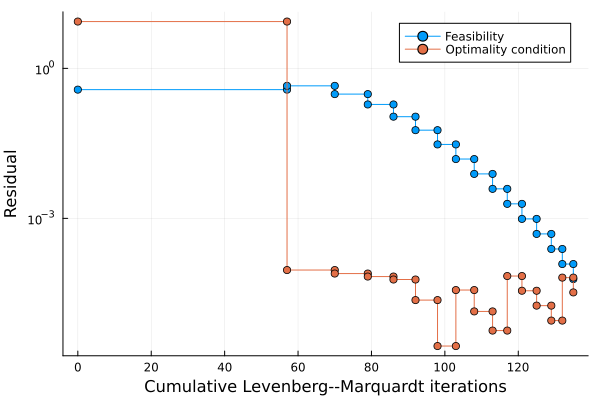

In [139]:
plot(itr, feasibility_res, shape=:circle, label="Feasibility")
plot!(itr, optimality_res, shape=:circle, label="Optimality condition")
plot!(yscale = :log10, xlabel = "Cumulative Levenberg--Marquardt iterations", ylabel = "Residual")

In [140]:
mu = vcat([[2^i;2^i] for i=0:length(cummulative_lmiters)]...)


32-element Vector{Int64}:
     1
     1
     2
     2
     4
     4
     8
     8
    16
    16
     ⋮
  2048
  4096
  4096
  8192
  8192
 16384
 16384
 32768
 32768

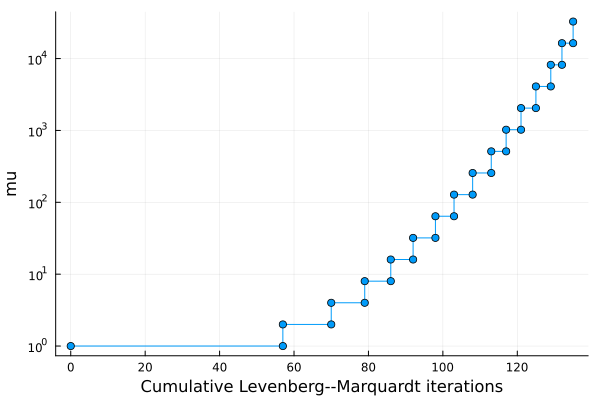

In [141]:

plot(itr, mu[1:end-1], shape=:circle, legend=false)
plot!(yscale = :log10, xlabel = "Cumulative Levenberg--Marquardt iterations", ylabel="mu")

## 19.3 Augmented Lagrangian algorithm 

**Augmented Lagrangian.** 

\begin{align}
    L_\mu (x,z) = L(x, z) + \mu ||g(x)||^2 = ||f(x)||^2 + g(x)^T z + \mu ||g(x)||^2.
\end{align}

You can think of this as the Lagrangian augmented with the new term $\mu ||g(x)||^2$ or it can be interpreted as the composite objective function used in the penalty algorithm with the Lagrange multiplier term $g(x)^T z$ added.

The augmented Lagrangian is also the ordinary Lagrangian associated with the problem 

\begin{align}
    & \text{minimize} \quad ||f(x)||^2 + \mu ||g(x)||^2 \\
    & \text{subject to} \quad g(x) = 0
\end{align}

**Minimizing the augmented Lagrangian** 

We can rewrite the augmented Lagrangian by using the identity 

\begin{align}
    \mu ||g(x) + \frac{z}{2\mu}||^2 &= \\
                                    &= \mu||g(x)||^2 + 2\mu g(x) \frac{z}{2\mu} + \mu ||\frac{z}{2\mu}||^2 \\
                                    &= \mu||g(x)||^2 + g(x)^Tz + \mu ||\frac{z}{2\mu}||^2
\end{align}

and therefore, 
\begin{align}
    \mu ||g(x) + \frac{z}{2\mu}||^2 - \mu ||\frac{z}{2\mu}||^2 = \mu||g(x)||^2 + g(x)^Tz
\end{align}

We substitue the right hand for the left hand in the original augmented Lagrangian equation to then get: 

\begin{align}
    L_\mu (x,z) = ||f(x)||^2 + \mu ||g(x) + \frac{z}{2\mu}||^2 - \mu ||\frac{z}{2\mu}||^2
\end{align}

When we minimize $L_\mu(x,z)$ over the variable $x$ (fixing $\mu$ and $z$), the last term $-\mu ||\frac{z}{2\mu}||^2$ us a constant and does not affect the choice of $x$. We can then minimize $L_\mu(x,z)$ over $x$ by minimizing the function

\begin{align}
    ||f(x)||^2 + \mu ||g(x) + \frac{z}{2\mu}||^2 
\end{align}

which in term can be expressed as

\begin{align}
    \left\Vert \begin{bmatrix}
            f(x) \\
            \sqrt{\mu} g(x) + \frac{z}{2\sqrt{\mu}}
          \end{bmatrix} \right\Vert^2
\end{align}

This can be (approximately) minimized using the Levenberg-Marquardt algorithm. 

Any minimizer $\tilde x$ of $L_\mu (x,z)$ satisfies the optimality condition 

\begin{align}
    & 2Df(\tilde x)^Tf(\tilde x) + 2 \mu Dg(\tilde x)^T (g(\tilde x) + \frac{z}{2\mu}) = 0\\
    = \quad & 2Df(\tilde x)^Tf(\tilde x) + Dg(\tilde x)^T (2 \mu g(\tilde x) + z) = 0
\end{align}

We observe that if $\tilde x$ minimizes the augmented Lagrangian and is also feasible ($g(\tilde x) = 0$)m then it satisfies the optimality condition with $z$ as the Lagrange multiplier. The bottom equation suggests a good choice for updating the Lagrange multiplier $z$ if $\tilde x$ is not feasible: 

\begin{align}
    \tilde z = z + 2\mu g(\tilde x)
\end{align}

The augmented Lagrangian algorithm then alternates between minimizing the augmented Lagrangian using the Levenberg-Marquardt algorithm to update $\tilde x$, and updating the estimated Lagrange multiplier $z$ using the suggestion above. The penalty parameter $\mu$ is only increased when needed, when $||g(x)||$ does not sufficiently decrease. 

**Algorithm 19.2** $\text{AUGMENTED LAGRANGIAN ALGORITHM}$\
$\textbf{given } \text{differentiable functions } f: \R^n \to \R^m \text{ and } g: \R^n \to \R^p, \text{ and an initial point } x^{(1)}. \text{Set } z^{(1)} = 0, \mu^{(1)} = 1.$\
$\text{For } k = 1,2,\dots,k^{max}$
1. $\textit{Solve unconstrained nonlinear least squares problem. } \text{Set } x^{(k+1)} \text{ to be the (approximate) minimizer of}$
\begin{align}
    ||f(x)||^2 + \mu^{(k)} ||g(x) + z^{(k)} / (2\mu^{(k)})||^2
\end{align}
$\quad \text{Levenberg-Marquardt algorithm, starting from initial point }x^{(k)}.$
2. $\textit{Update }z^{(k)}.$
\begin{align}
    z^{(k+1)} = z^{(k)} + 2 \mu^{(k)} g(x^{(k+1)}).
\end{align}
3. $\textit{Update }\mu^{(k)}.$
\begin{align}
    \mu^{(k+1)} = \begin{cases}
        \mu^{(k)} & ||g(x^{(k+1)})|| < 0.25 ||g(x^{(k)})|| \\
        2\mu^{(k)} & ||g(x^{(k+1)})|| \geq 0.25 ||g(x^{(k)})||.
    \end{cases}
\end{align}

The augmented Lagrangian algorithm is stopped early if $g(x^{(k)})$ is very small. This algoirthm is not much more complicated than the penalty algorithm, but it works much better in practice. In part this is because the penalty parameter $\mu^{(k)}$ does not need to increase as much as the algorithm proceeds. 

In [156]:
using VMLS 
using LinearAlgebra

function augmented_lagrangian(f, Df, g, Dg, x1, lambda1; kmax=100, feas_tol=1e-4, oc_tol=1e-4)
    p = length(g(x1))
    z = zeros(p)
    mu = 1
    x_k = x1
    feass = [norm(g(x_k))]
    ocs = [norm(2 * Df(x_k)'*f(x_k) + 2 * Dg(x_k)'*z)]
    lm_iters = zeros(0,1)
    for k=1:kmax
        lm_f(x) = [f(x); sqrt(mu)*g(x) + z/(2*sqrt(mu))];
        Dlm_f(x) = [Df(x); sqrt(mu) * Dg(x)];
        #println(size(Dlm_f(x_k)))
        x_k, iterdata = levenberg_marquardt(lm_f, Dlm_f, x_k, lambda1, tol=oc_tol)
        oc = iterdata["residuals"][end]
        ocs = [ocs; oc]
        lm_iter = length(iterdata["residuals"])
        lm_iters = [lm_iters; lm_iter]
        feas = norm(g(x_k))
        #println(feas)
        feass = [feass; feas]
        if feas < feas_tol # && oc < oc_tol
            break
        end
        z = z + (2*mu*g(x_k))
        mu = feas < .25*feass[end-1] ? mu : 2*mu; 
        #println(mu)
    end;
    return x_k, z, Dict([("lm_iters", lm_iters), ("feasibility_res", feass), ("optimality_res", ocs)])
end;

In [157]:
x, z, hist = augmented_lagrangian(f, Df, g, Dg, [.5, -.5], 1.0);
x, z

([-1.864661485610974e-5, -1.5008567820056915e-5], [-1.9996888876905063])

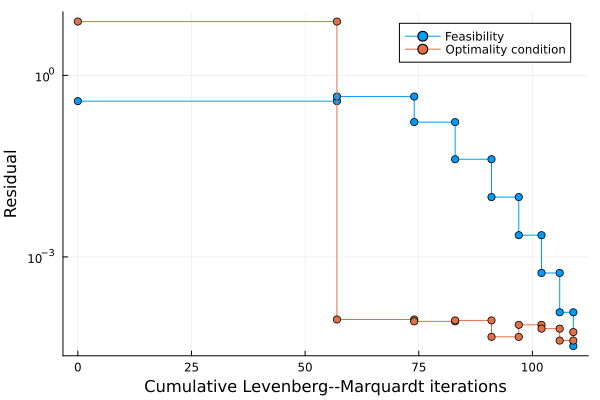

In [158]:
using Plots 

cummulative_lmiters = cumsum(hist["lm_iters"], dims=1)
itr = vcat([0], [[i;i] for i in cummulative_lmiters]...)
feasibility_res = vcat([[r;r] for r in hist["feasibility_res"][1:end-1]]..., hist["feasibility_res"][end]) 
optimality_res = vcat([[r;r] for r in hist["optimality_res"][1:end-1]]..., hist["optimality_res"][end])
plot(itr, feasibility_res, shape=:circle, label="Feasibility")
plot!(itr, optimality_res, shape=:circle, label="Optimality condition")
plot!(yscale = :log10, xlabel = "Cumulative Levenberg--Marquardt iterations", ylabel = "Residual")

In [159]:
feasibility_res

17-element Vector{Float64}:
 0.375
 0.375
 0.4465809000031187
 0.4465809000031187
 0.16901212978298752
 0.16901212978298752
 0.04112054297119078
 0.04112054297119078
 0.009738757933589734
 0.009738757933589734
 0.0022852085069924874
 0.0022852085069924874
 0.0005437199036877575
 0.0005437199036877575
 0.00012159175357910502
 0.00012159175357910502
 3.3654957425542005e-5

In [161]:
optimality_res

17-element Vector{Float64}:
 7.74894493388193
 7.74894493388193
 9.246112331528868e-5
 9.246112331528868e-5
 8.62067763224663e-5
 8.62067763224663e-5
 8.928146157619509e-5
 8.928146157619509e-5
 4.777121845544459e-5
 4.777121845544459e-5
 7.549231287785949e-5
 7.549231287785949e-5
 6.530462564138708e-5
 6.530462564138708e-5
 4.1418536721504076e-5
 4.1418536721504076e-5
 5.720320737630413e-5

In [162]:
itr

17-element Vector{Float64}:
   0.0
  57.0
  57.0
  74.0
  74.0
  83.0
  83.0
  91.0
  91.0
  97.0
  97.0
 102.0
 102.0
 106.0
 106.0
 109.0
 109.0